In [1]:
import pandas as pd
import numpy as np
train_data = pd.read_csv("./boston-housing/train.csv")

FileNotFoundError: [Errno 2] File b'./boston-housing/train.csv' does not exist: b'./boston-housing/train.csv'

In [ ]:
train_data.head()

In [354]:
## Get first 13 columns as X
X = train_data.values[:, 1:-1]

## Normalize X
mean = X.mean(axis = 0)
std = X.std(axis = 0)
X_normalized = (X - mean)/std

## Get last columns as y
y = train_data.values[:,-1].reshape((X.shape[0],1))

In [356]:
## X: N x D matrix
## y: N x 1 matrix
## beta: D x 1 matrix

def compute_loss(X, y, beta):
    y_pred = X.dot(beta)
    loss = 1/2 * ((y_pred - y)**2).mean()
    return loss

def compute_gradient(X, y, beta):
    N = X.shape[0]
    grad = 1/N * X.T.dot(X.dot(beta) - y)
    return grad

In [358]:
## Gradient Decent 

# Initialize weight value:
np.random.seed(1)


beta = np.zeros((X.shape[1],1))


num_steps = 5000

## fixed learning rate
learning_rate = 0.0001

losses = []
for step in range(num_steps):
    loss = compute_loss(X_normalized, y, beta)
    losses.append(loss)
    grad = compute_gradient(X_normalized, y, beta)
    beta = beta - learning_rate * grad
    
    if step %1000 == 0:
        print('*'*50)
        print("Step", step, "Loss value", loss)


**************************************************
Step 0 Loss value 301.1583183183183
**************************************************
Step 1000 Loss value 287.6080933073323
**************************************************
Step 2000 Loss value 282.2446510006824
**************************************************
Step 3000 Loss value 279.5445889357863
**************************************************
Step 4000 Loss value 277.8442352856552


In [360]:
## Accelerated Gradient Decent 

# Initialize weight value:
np.random.seed(1)



beta = np.zeros((X.shape[1],1))
last_beta = beta

num_steps = 5000

## fixed learning rate
learning_rate = 0.0001

acc_losses = []
for step in range(num_steps):
    loss = compute_loss(X_normalized, y, beta)
    acc_losses.append(loss)
    if step == 0:
        grad = compute_gradient(X_normalized, y, beta)
        last_beta = beta
        beta = beta - learning_rate * grad
    else:
        v = beta + (step-1)/(step+2) * (beta - last_beta)
        last_beta = beta
        grad = compute_gradient(X_normalized, y, v) 
        beta = v - learning_rate * grad      
    if step %1000== 0:
        print('*'*50)
        print("Step", step, "Loss value", loss)


**************************************************
Step 0 Loss value 301.1583183183183
**************************************************
Step 1000 Loss value 270.49749428340317
**************************************************
Step 2000 Loss value 270.4154693190335
**************************************************
Step 3000 Loss value 270.4056178910377
**************************************************
Step 4000 Loss value 270.4034772463922


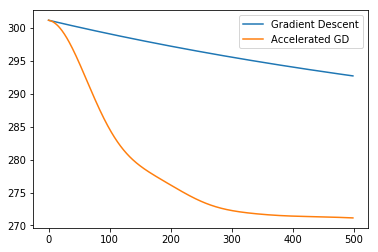

In [369]:
plt.plot(losses[:500], label = 'Gradient Descent')
plt.plot(acc_losses[:500], label = 'Accelerated GD')
plt.legend()
plt.show()